## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [1]:
# imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg

## First, I'll compute the camera calibration using chessboard images

In [2]:
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## If the above cell ran sucessfully, you should now have `objpoints` and `imgpoints` needed for camera calibration.  Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!
The coefficients are dumped to pickle file so that the calibration is not needed next time. 
Note here I picked four images with increasing lane detection difficulty. First one is just straight line. The other 3 are screenshots from the challenge.mp4, with dividing line, partially shadow and big trunk of shadow covered area.

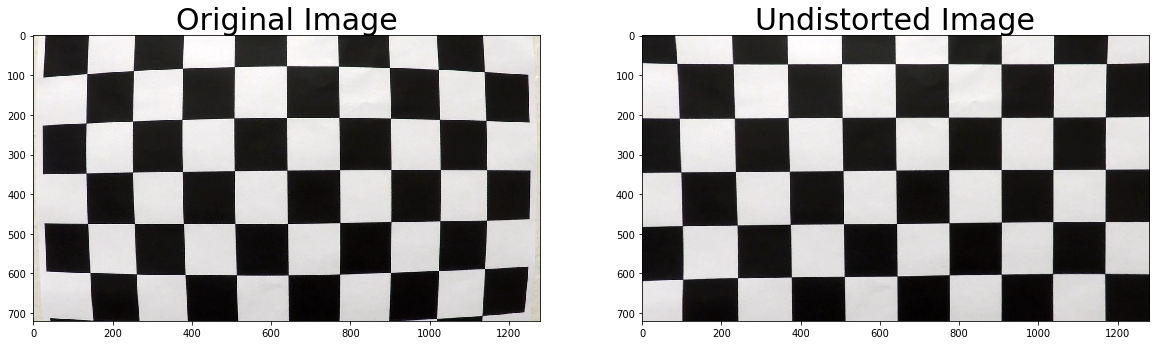

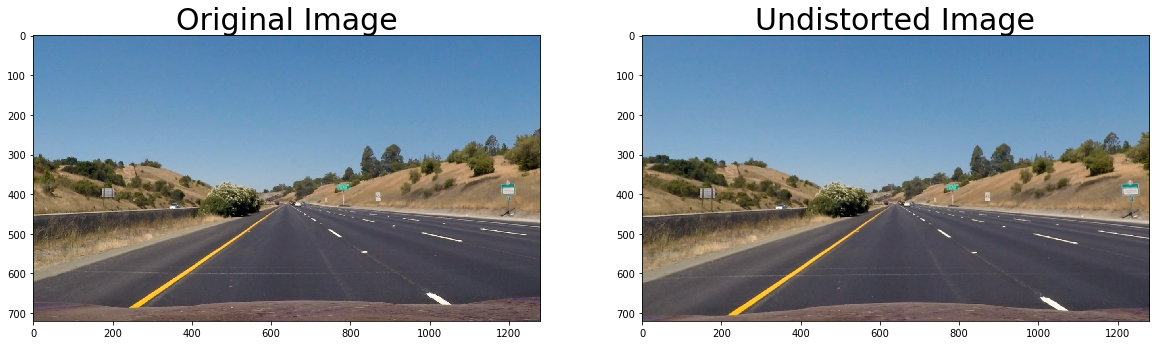

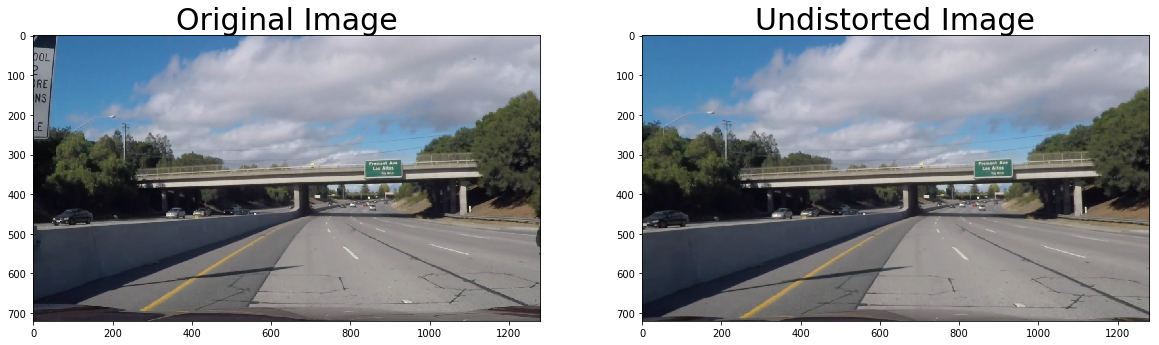

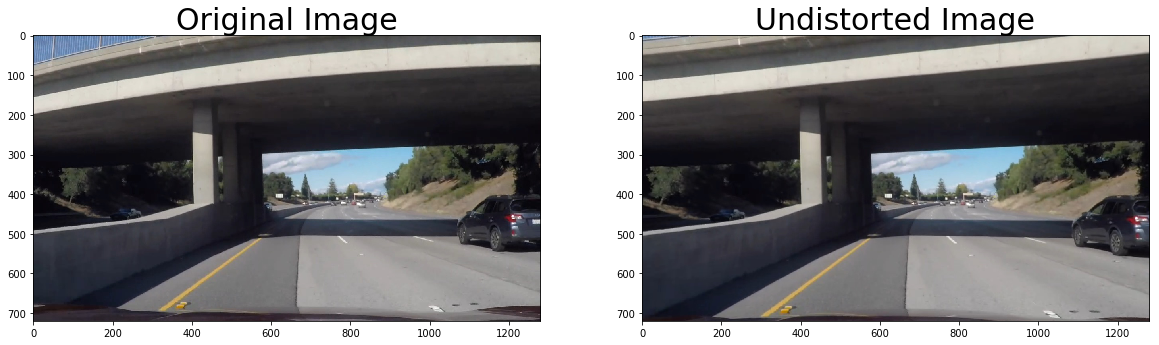

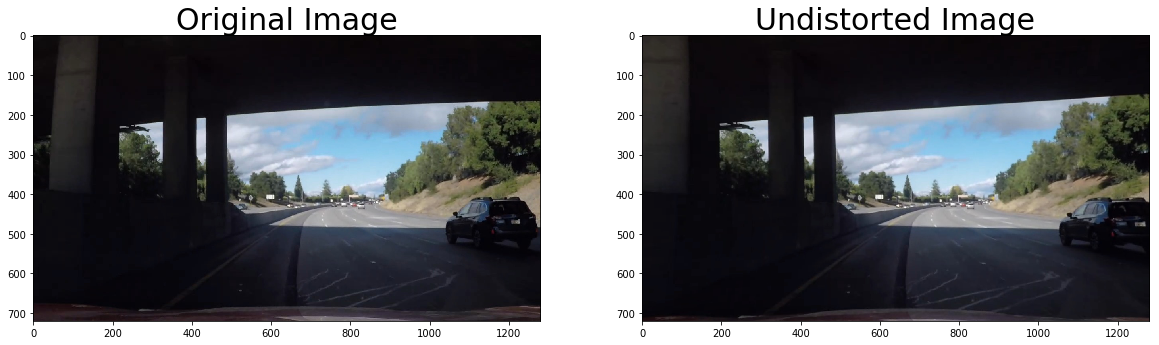

In [107]:
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('../camera_cal/test_img.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "../camera_cal/wide_dist_pickle.p", "wb" ) )

# load dist pickle
def read_mtx_dist():
    file = open("../camera_cal/wide_dist_pickle.p",'rb')
    dist_pickle = pickle.load(file)
    file.close()
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    return mtx, dist

mtx, dist = read_mtx_dist()

def remove_distortion(img, mtx, dist, quiet = True):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    #cv2.imwrite('../camera_cal/test_undist.jpg',dst)
    if(quiet == False):
        # Visualize undistortion
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image', fontsize=30)
    return dst

remove_distortion(img, mtx, dist, False)
# Read in an image
img = cv2.imread('../test_images/straight_lines1.jpg')
height = img.shape[0]
width = img.shape[1]

# Read in screenshots from challenge_video.mp4
img_hard = cv2.imread('../test_images/Cha1.jpg')
img_hard_shadow = cv2.imread('../test_images/Cha2.jpg')
img_hard_shadow2 = cv2.imread('../test_images/Cha3.jpg')

undistort = remove_distortion(img, mtx, dist, False)
undistort_hard = remove_distortion(img_hard, mtx, dist, False)
undistort_hard_shadow = remove_distortion(img_hard_shadow, mtx, dist, False)
undistort_hard_shadow2 = remove_distortion(img_hard_shadow2, mtx, dist, False)

### Apply perspective transform to the undistorted image
Generate the bird-eyeview of the lane area. Note the upper part of the yellow line of the 2nd warped image is quite blury, which is expected since upper part will turn narrow on the upward. This will affect the precision of the poly fit for sure. The third warped image can hardly see the upper part of the yellow line. In the fourth warped image, the yellow line is merely visible.

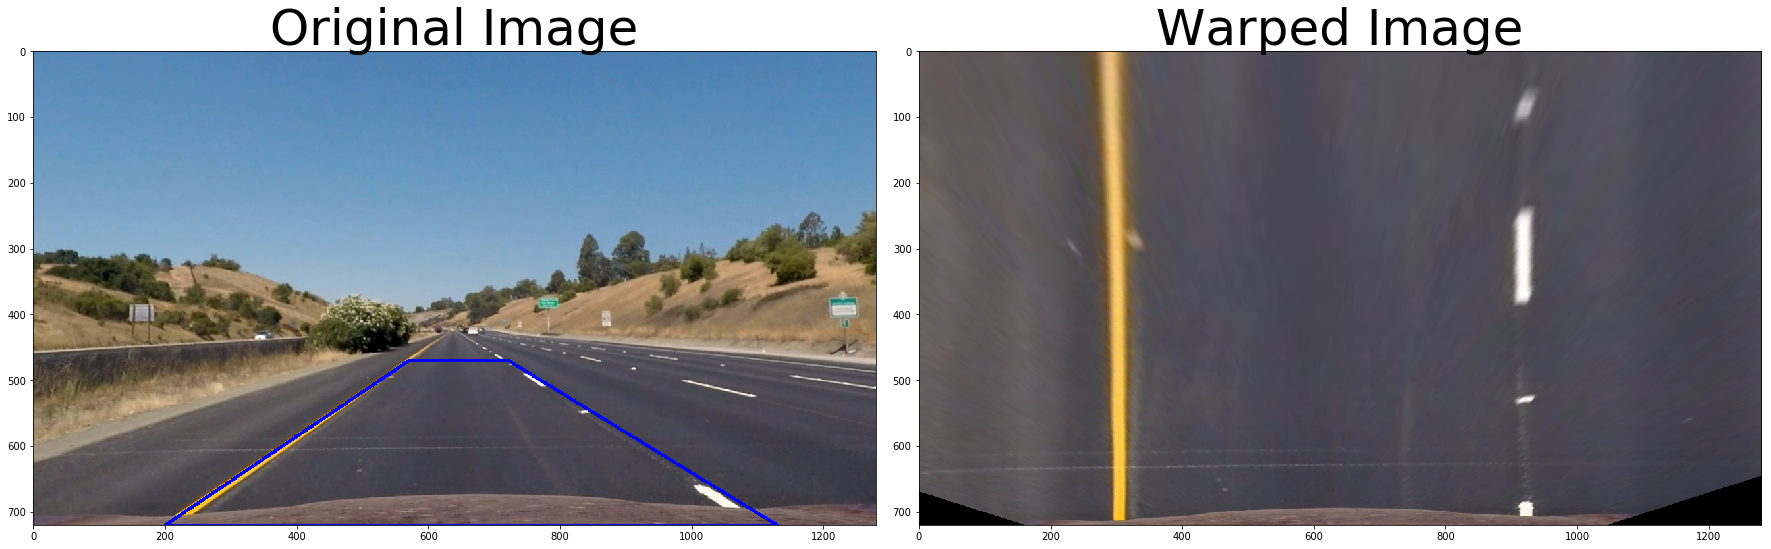

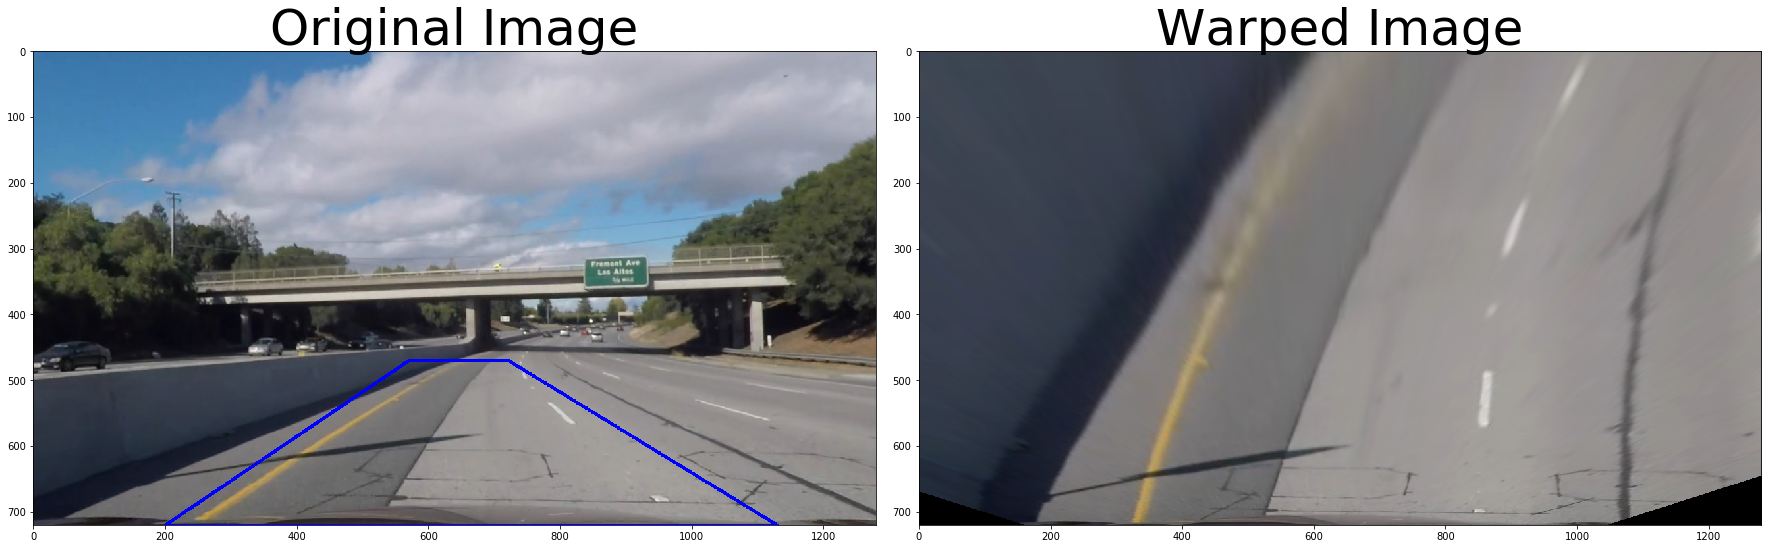

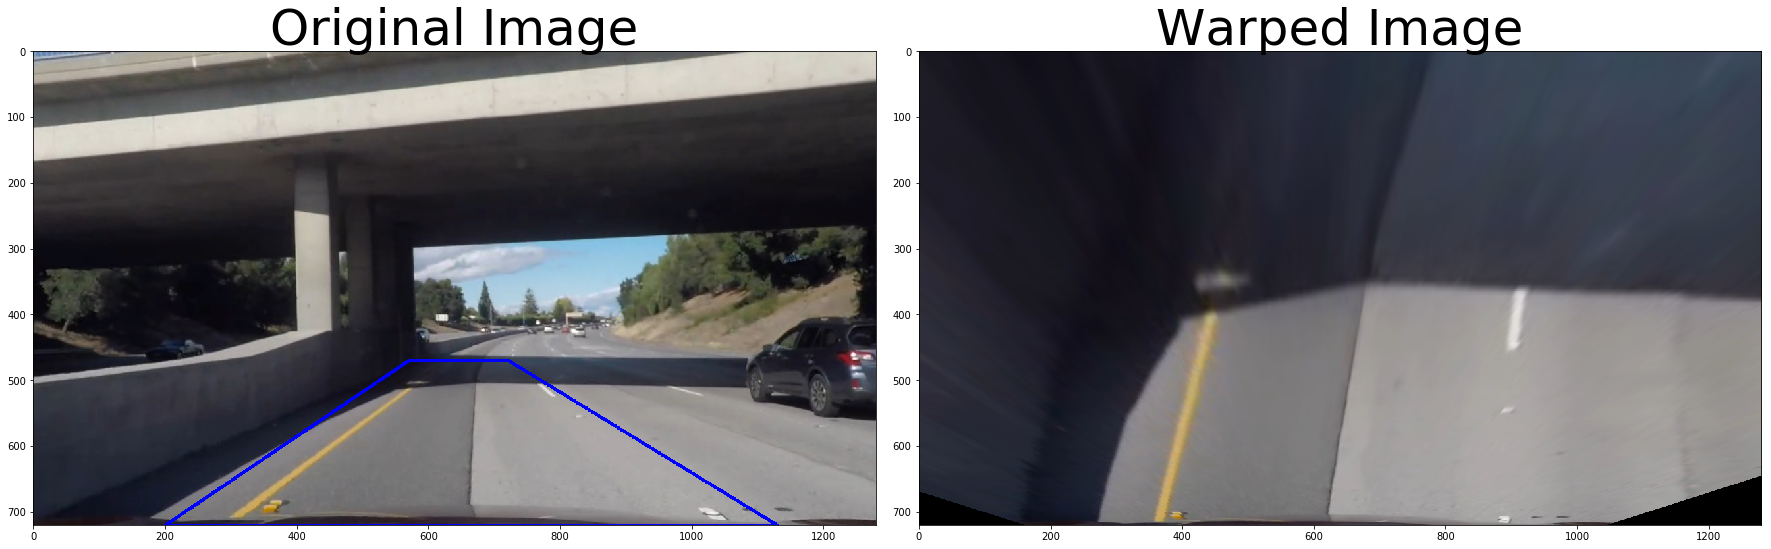

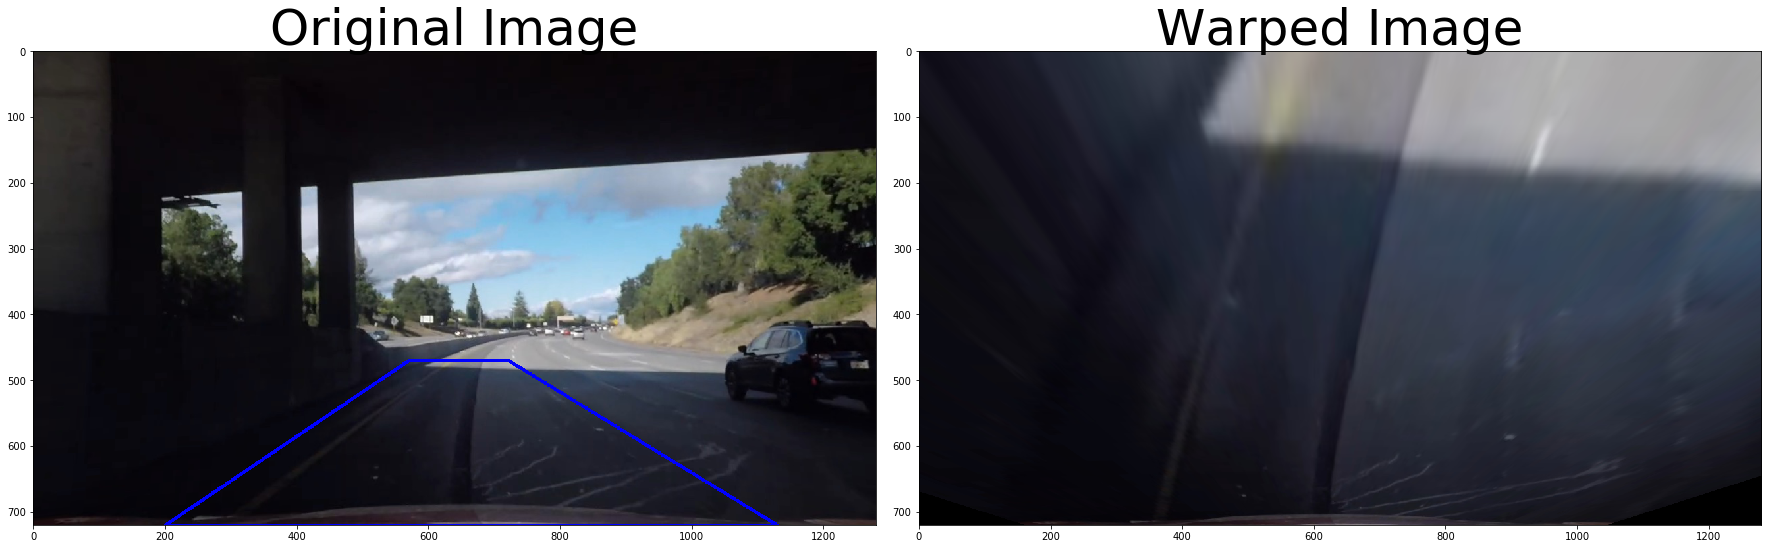

In [156]:
def apply_perspective_transform(undist, quiet = True):
    # Vertices extracted manually for performing a perspective transform
    bottom_left = [200,720]
    bottom_right = [1130, 720]
    top_left = [570, 470]
    top_right = [722, 470]

    source = np.float32([bottom_left,bottom_right,top_right,top_left])

    pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
    pts = pts.reshape((-1,1,2))
    copy = undist.copy()
    image_shape = img.shape
    cv2.polylines(copy,[pts],True,(255,0,0), thickness=3)

    # Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
    bottom_left = [300,720]
    bottom_right = [940, 720]
    top_left = [300, 1]
    top_right = [940, 1]

    dst = np.float32([bottom_left,bottom_right,top_right,top_left])
    M = cv2.getPerspectiveTransform(source, dst)
    M_inv = cv2.getPerspectiveTransform(dst, source)
    img_size = (image_shape[1], image_shape[0])

    warped = cv2.warpPerspective(undist, M, img_size , flags=cv2.INTER_LINEAR)

    if(quiet == False):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(cv2.cvtColor(copy, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB), cmap='gray')
        ax2.set_title('Warped Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return warped, M_inv

warped, M_inv = apply_perspective_transform(undistort, quiet = False)
warped_hard, _ = apply_perspective_transform(undistort_hard, quiet = False)
warped_hard_shadow, _ = apply_perspective_transform(undistort_hard_shadow, quiet = False)
warped_hard_shadow2, _ = apply_perspective_transform(undistort_hard_shadow2, quiet = False)

### Create a thresholded binary image.
Multiple channels are tested as below:
1. S Channel of HLS
2. Sobel x
3. Sobel y
4. Combined S channel and Sobel x
5. L Channel of LUV
6. B Channel of LAB
7. Combined L channel and B channel

Comparing these channels we can see Sobel y is very noisy and almost useless. S channel and Sobel x can together render meaningful results for the happy case, while in the challege.mp4 vedio, since the lane is divided into two different colors the x sobel channel has lots of noise as well. L Channel of the LUV space can ideally detect white lanes. B Channel of LAB does a good job finding yellow lines. So the final results is a union of B Channel, L Channel and S Channel. Out of the 3, L and B provide most of the info while S channel can only get a subset of B channel. So L and B channel could be sufficient for most of the scenarios. S is more like a safeguard. However, for the lanes under low light circumstances, like image 3 and 4, even this approach stopped working. I also tried common tricks like image histogram equalization. Seems it does not help at all.

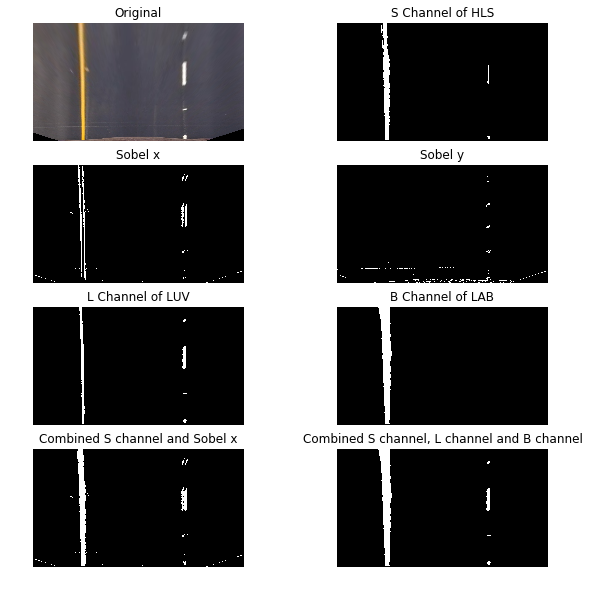

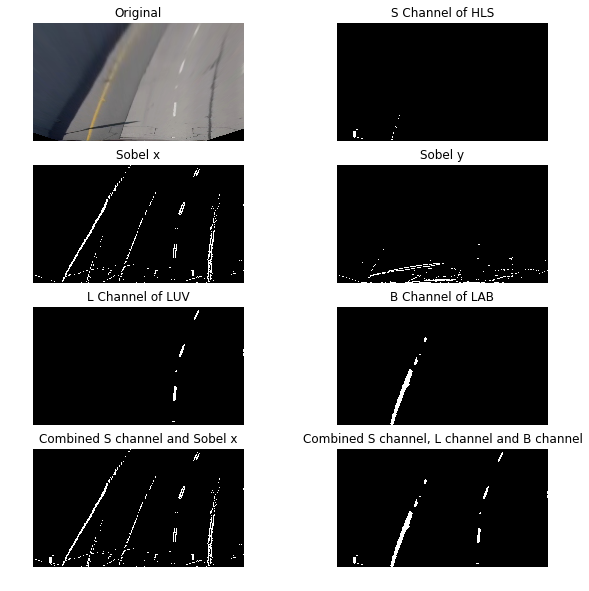

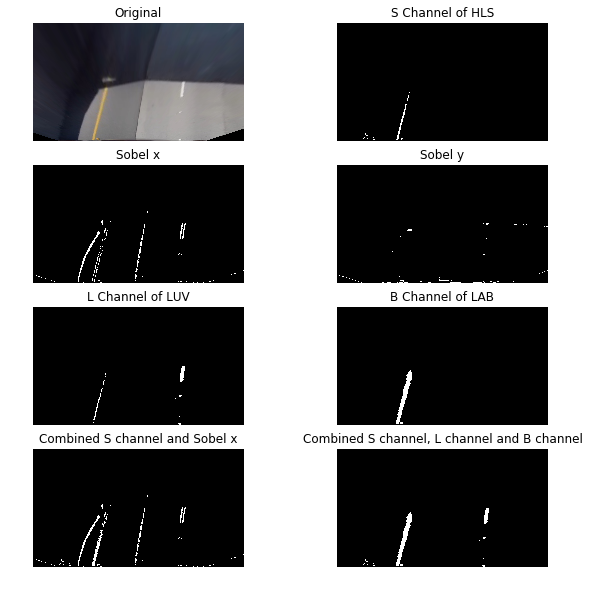

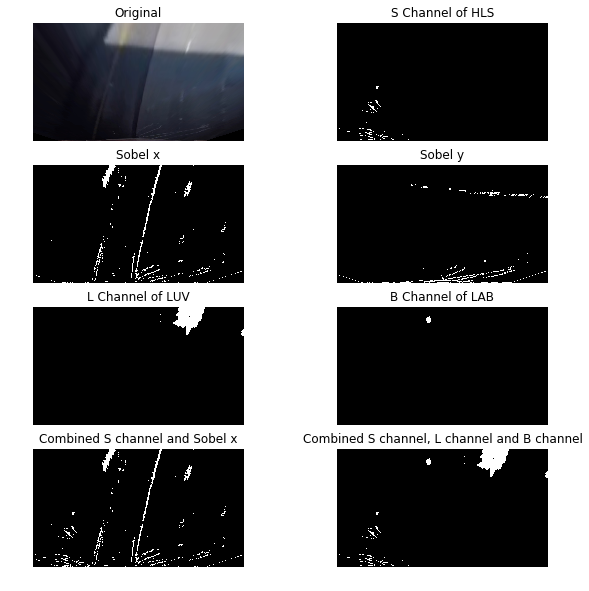

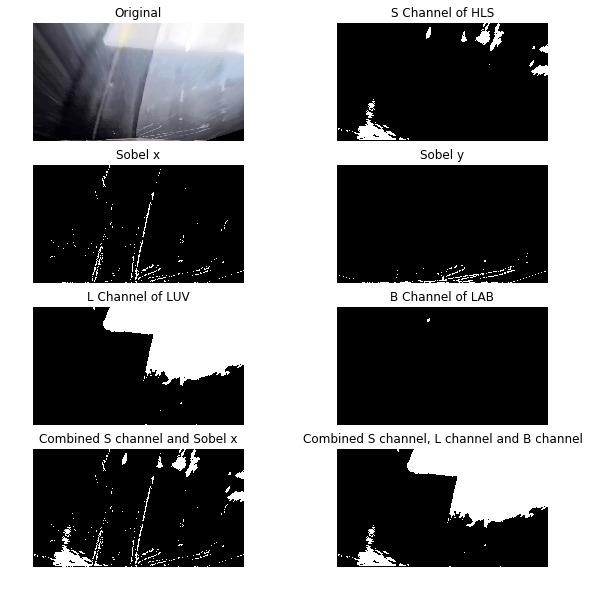

In [193]:
def apply_threshold(img, mtx, dist, quiet = True):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]

    # Threshold color channel
    s_thresh_min = 100
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    
    luv = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    l_channel = luv[:,:,0]
    l_thresh_min = 180
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   

    b_thresh_min = 140
    b_thresh_max = 220
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1

    
    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient, noisy in many circumstances
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Sobel y
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1) # Take the derivative in y
    abs_sobely = np.absolute(sobely) # Absolute y derivative to accentuate lines away from vertical
    scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))

    # Threshold y gradient, note it's not used due to noise
    sybinary = np.zeros_like(scaled_sobel)
    sybinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Combine the two binary thresholds
    combined_binary_x = np.zeros_like(sxbinary)
    combined_binary_x[(sxbinary == 1) | (s_binary == 1)] = 1
    
    combined = np.zeros_like(sybinary)
    combined[(s_binary == 1) | (b_binary == 1) | (l_binary == 1)] = 1
    
    if(quiet == False):
        # Plotting thresholded images
        f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows=4, ncols=2, figsize=(10,10))
        ax1.axis('off')
        ax1.set_title('Original')
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        ax2.axis('off')
        ax2.set_title('S Channel of HLS')
        ax2.imshow(s_binary, cmap='gray')

        ax3.axis('off')
        ax3.set_title('Sobel x')
        ax3.imshow(sxbinary, cmap='gray')

        ax4.axis('off')
        ax4.set_title('Sobel y')
        ax4.imshow(sybinary, cmap='gray')

        ax5.axis('off')
        ax5.set_title('L Channel of LUV')
        ax5.imshow(l_binary, cmap='gray')

        ax6.axis('off')
        ax6.set_title('B Channel of LAB')
        ax6.imshow(b_binary, cmap='gray')
        
        ax7.axis('off')
        ax7.set_title('Combined S channel and Sobel x')
        ax7.imshow(combined_binary_x, cmap='gray')

        ax8.axis('off')
        ax8.set_title('Combined S channel, L channel and B channel')
        ax8.imshow(combined, cmap='gray')
        
    return combined

combined = apply_threshold(warped, mtx, dist, quiet = False)
combined_hard = apply_threshold(warped_hard, mtx, dist, quiet = False)
combined_hard_shadow = apply_threshold(warped_hard_shadow, mtx, dist, quiet = False)
combined_hard_shadow2 = apply_threshold(warped_hard_shadow2, mtx, dist, quiet = False)

img_yuv = cv2.cvtColor(warped_hard_shadow2, cv2.COLOR_BGR2YUV)

# equalize the histogram of the Y channel
img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

# convert the YUV image back to RGB format
img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
combined_hard_shadow2_eq = apply_threshold(img_output, mtx, dist, quiet = False)

### Line Finding Method: Peaks in a Histogram
The histogram and sliding window method works well when the binary output from previous step can present good results. For the most challenging image, the pipeline can't fit well due to lack of line points.

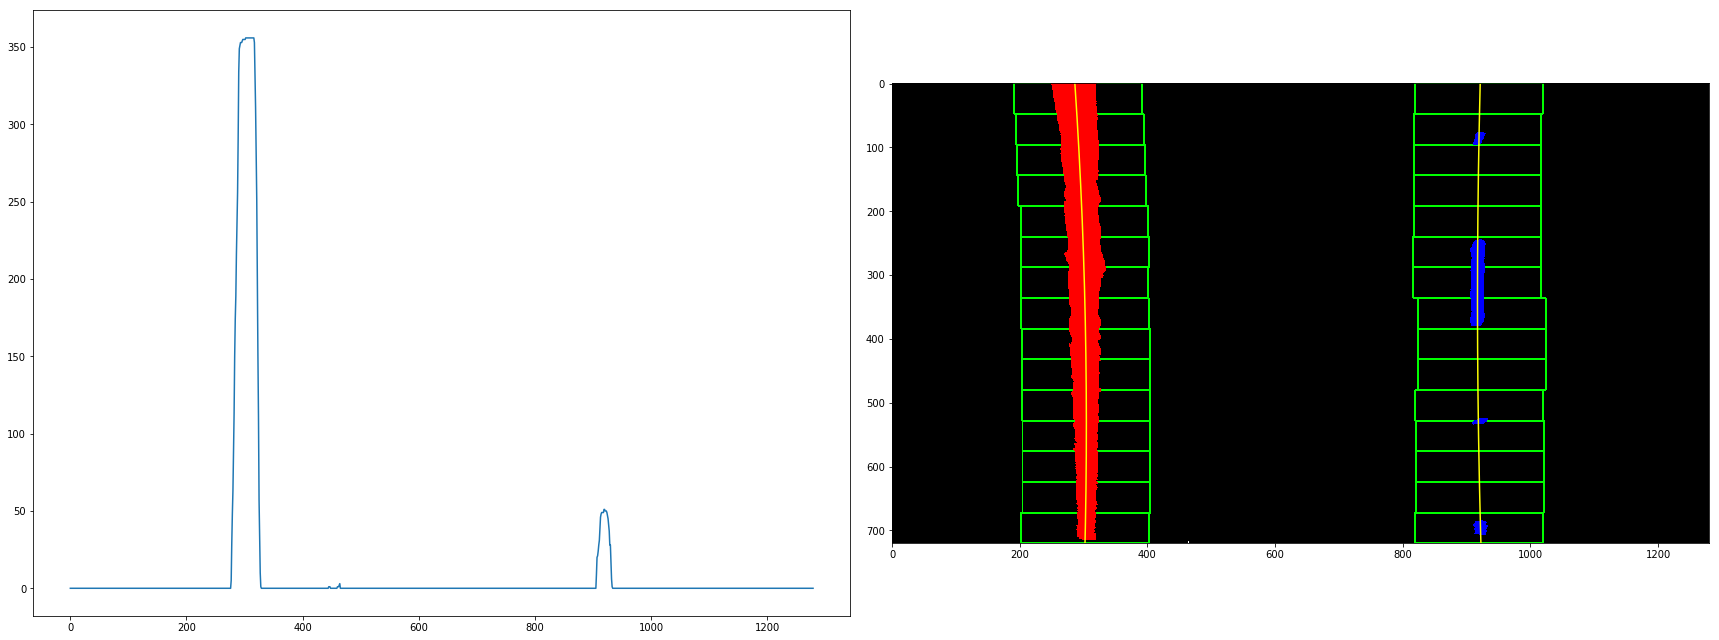

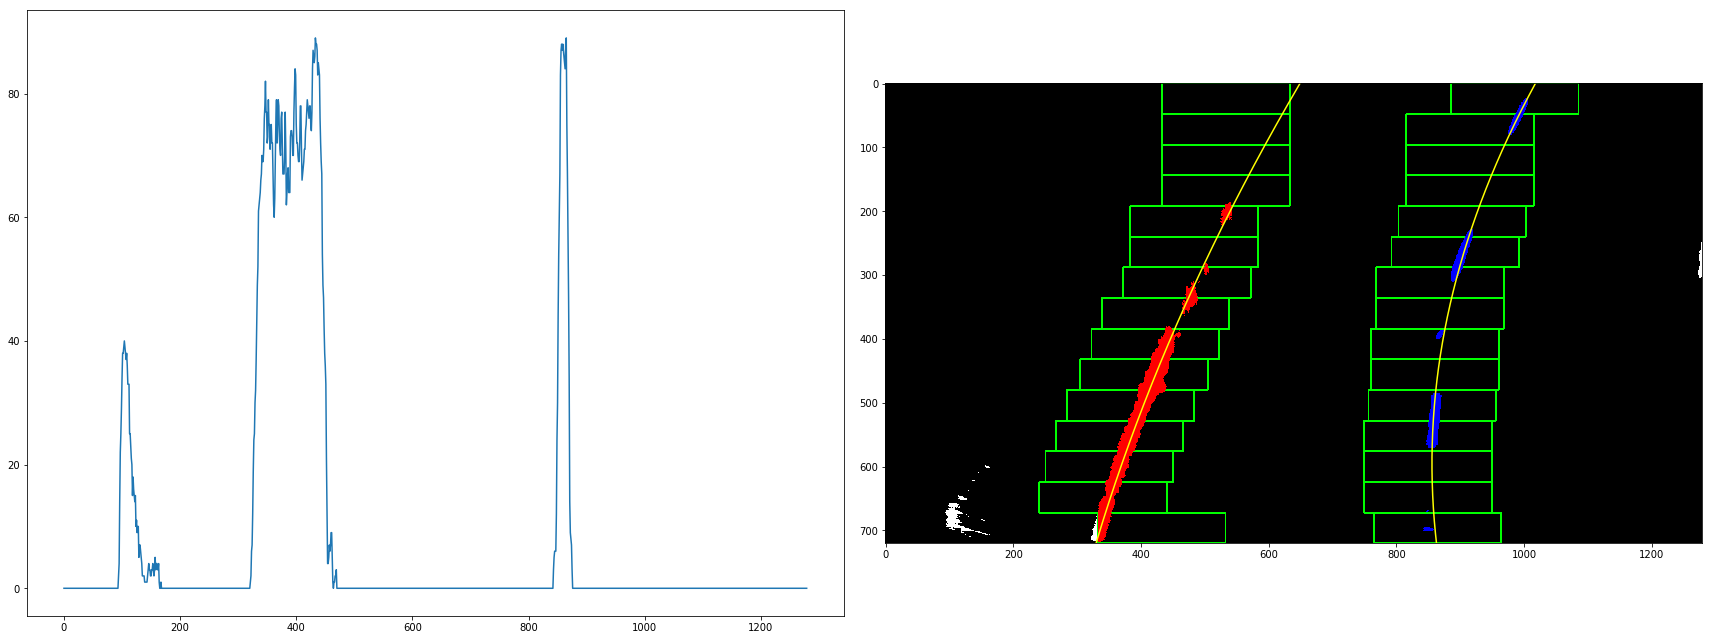

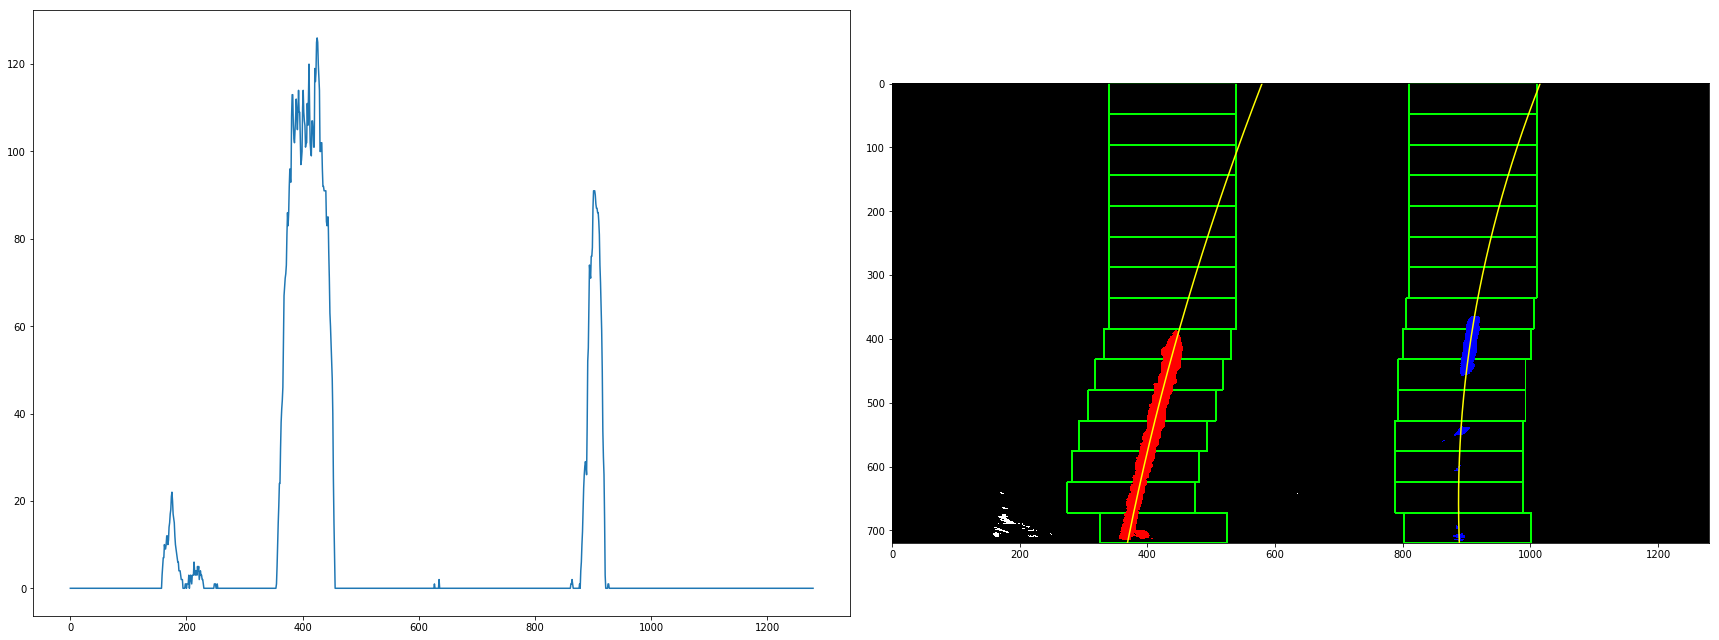

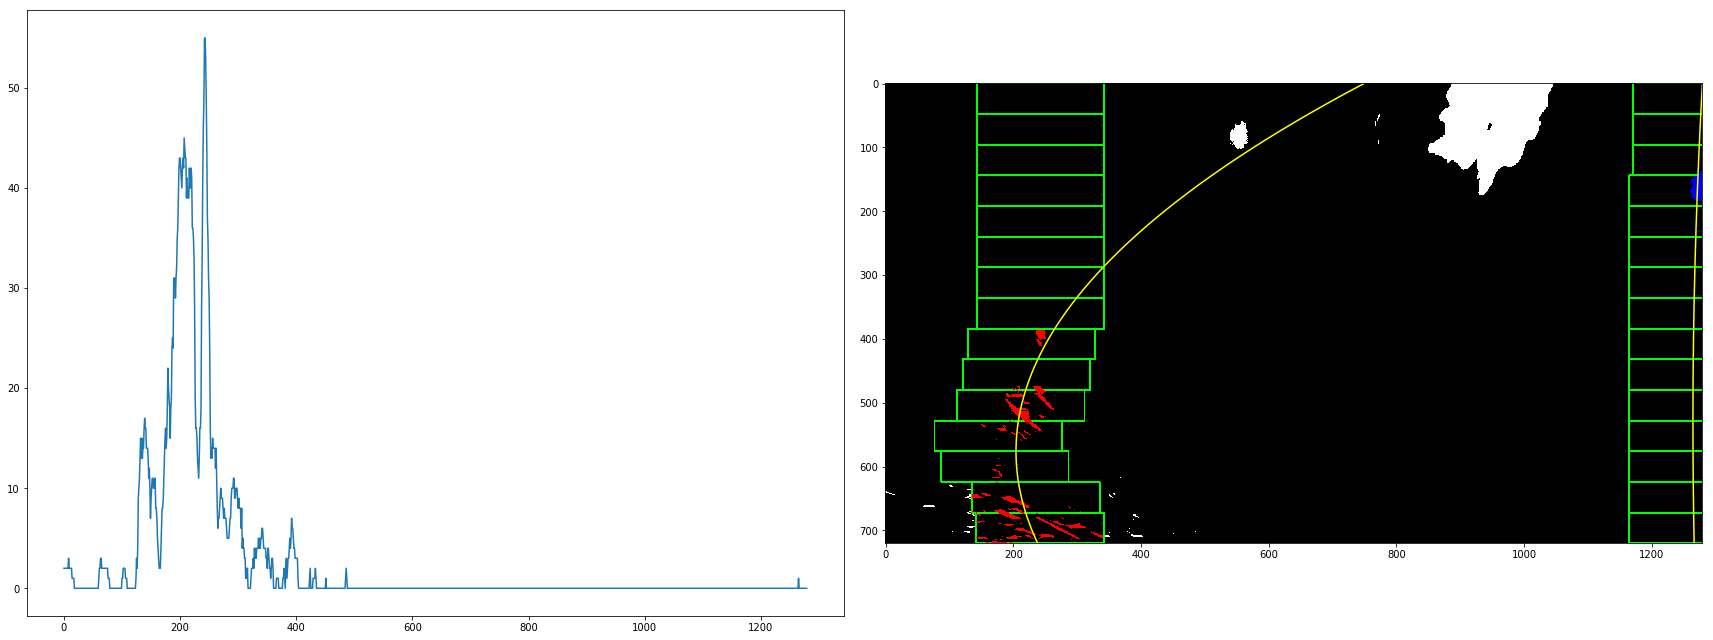

In [194]:
def find_lanes(binary_warped, quiet = True):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 15
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fitx = None
    right_fitx = None
    left_fit = None
    right_fit = None
    if(lefty.size and righty.size):
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        ploty = np.linspace(0, height-1, height)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        if(quiet == False):
            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()
            ax1.plot(histogram)
            ax2.imshow(out_img)
            ax2.plot(left_fitx, ploty, color='yellow')
            ax2.plot(right_fitx, ploty, color='yellow')
    return left_fit, right_fit, left_fitx, right_fitx

left_fit, right_fit, left_fitx, right_fitx = find_lanes(combined, quiet = False)
left_fit_hard, right_fit_hard, left_fitx_hard, right_fitx_hard = find_lanes(combined_hard, quiet = False)
left_fit_hard_shadow, right_fit_hard_shadow, left_fitx_hard_shadow, right_fitx_hard_shadow = find_lanes(combined_hard_shadow, quiet = False)
left_fit_hard_shadow2, right_fit_hard_shadow2, left_fitx_hard_shadow2, right_fitx_hard_shadow2 = find_lanes(combined_hard_shadow2, quiet = False)

### Skip the sliding windows step once we know where the lines are
Last step is more like a blind search from histgram, which won't be necessary once we got the fitting parameters. Still last image does not render good prediction. 

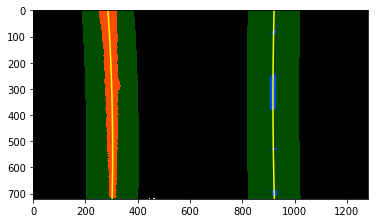

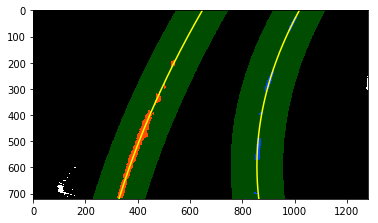

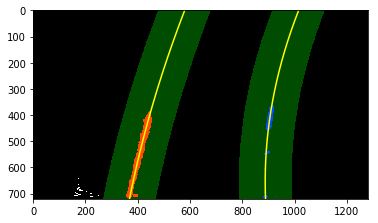

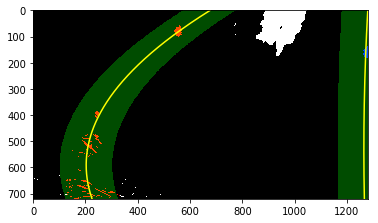

In [195]:
def find_lanes_next_frame(binary_warped, left_fit, right_fit, quiet = True):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fitx = None
    right_fitx = None
    if(lefty.size and righty.size):
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        ploty = np.linspace(0, height-1, height)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
        # Draw the lane onto the warped blank image
        if(quiet == False):
            # Create an image to draw on and an image to show the selection window
            out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
            window_img = np.zeros_like(out_img)
            # Color in left and right line pixels
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
            result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
            plt.figure()
            plt.imshow(result)
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)
    return left_fitx, right_fitx

left_fitx, right_fitx = find_lanes_next_frame(combined, left_fit, right_fit, quiet = False)
left_fitx_hard, right_fitx_hard = find_lanes_next_frame(combined_hard, left_fit_hard, right_fit_hard, quiet = False)
left_fitx_hard_shadow, right_fitx_hard_shadow = find_lanes_next_frame(combined_hard_shadow, left_fit_hard_shadow, right_fit_hard_shadow, quiet = False)
left_fitx_hard_shadow2, right_fitx_hard_shadow2 = find_lanes_next_frame(combined_hard_shadow2, left_fit_hard_shadow2, right_fit_hard_shadow2, quiet = False)

### Determine the curvature of the lane and vehicle position with respect to center
The observation is that in most of the frames, offset are small (within 0.5m). But curvature is between 500m and 5km, as hinted.

In [196]:
def measure_curvature(x_values):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # If no pixels were found return None
    y_points = np.linspace(0, height-1, height)
    y_eval = np.max(y_points)
    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

def get_radius_curvature_and_center_offset(left_fitx, right_fitx, quiet = True):
    left_curve_rad = measure_curvature(left_fitx)
    right_curve_rad = measure_curvature(right_fitx)
    lane_curvature = (left_curve_rad + right_curve_rad)/2
    
    # compute vehicle pos
    lane_center = (right_fitx[719] + left_fitx[719])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    vehicle_pos = xm_per_pix*center_offset_pixels
    if(quiet == False):
        offset_string = "Vehicle Pos: %.3f m" % vehicle_pos
        print(offset_string)
        curvature_string = "Lane curvature: %.3f m" % lane_curvature
        print(curvature_string)
    return vehicle_pos, lane_curvature

vehicle_pos, lane_curvature = get_radius_curvature_and_center_offset(left_fitx, right_fitx, quiet = False)
vehicle_pos_hard, lane_curvature_hard = get_radius_curvature_and_center_offset(left_fitx_hard, right_fitx_hard, quiet = False)
vehicle_pos_hard_shadow, lane_curvature_hard_shadow = get_radius_curvature_and_center_offset(left_fitx_hard_shadow, right_fitx_hard_shadow, quiet = False)
vehicle_pos_hard_shadow2, lane_curvature_hard_shadow2 = get_radius_curvature_and_center_offset(left_fitx_hard_shadow2, right_fitx_hard_shadow2, quiet = False)

Vehicle Pos: 0.146 m
Lane curvature: 3534.415 m
Vehicle Pos: 0.234 m
Lane curvature: 622.804 m
Vehicle Pos: 0.059 m
Lane curvature: 909.306 m
Vehicle Pos: 0.559 m
Lane curvature: 1615.616 m


### Project the result to original image

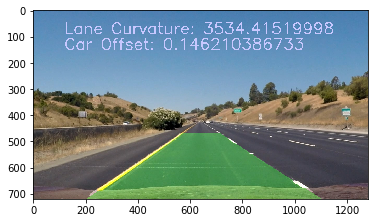

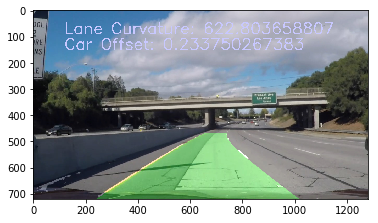

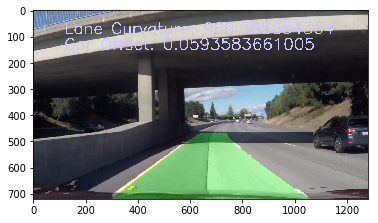

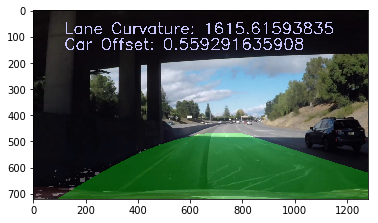

In [197]:
def hud(img, combined_binary_x, left_fitx, right_fitx, vehicle_pos, lane_curvature, M_inv, quiet = True):
    out_img = np.dstack((combined_binary_x, combined_binary_x, combined_binary_x))*255
    y_points = np.linspace(0, height-1, height)
    left_line_window = np.array(np.transpose(np.vstack([left_fitx, y_points])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_fitx, y_points]))))
    line_points = np.vstack((left_line_window, right_line_window))
    cv2.fillPoly(out_img, np.int_([line_points]), [0,255, 0])
    unwarped = cv2.warpPerspective(out_img, M_inv, img_size , flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
    cv2.putText(result, "Lane Curvature: " + str(lane_curvature), (120, 90), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,200,200), thickness=3)
    cv2.putText(result, "Car Offset: " + str(vehicle_pos), (120, 150), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,200,200), thickness=3)
    if(quiet == False):
        plt.figure()
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    return result
    
result = hud(img, combined, left_fitx, right_fitx, vehicle_pos, lane_curvature, M_inv, quiet = False)
result_hard = hud(img_hard, combined_hard, left_fitx_hard, right_fitx_hard, vehicle_pos_hard, lane_curvature_hard, M_inv, quiet = False)
result_hard_shadow = hud(img_hard_shadow, combined_hard_shadow, left_fitx_hard_shadow, right_fitx_hard_shadow, vehicle_pos_hard_shadow, lane_curvature_hard_shadow, M_inv, quiet = False)
result_hard_shadow2 = hud(img_hard_shadow2, combined_hard_shadow2, left_fitx_hard_shadow2, right_fitx_hard_shadow2, vehicle_pos_hard_shadow2, lane_curvature_hard_shadow2, M_inv, quiet = False)

### Compose the pipeline
The final pipeline composes the steps as illustrated above.
1. Remove distortion
2. Perspective transform
3. Apply threshold of S, L and B channel
4. If we got fitting parameters, we use them directly to get x points to plot the curve. There are several cases we have to start a blind search:
    a. The very beginning
    b. The lane curvature does not look valid. As mentioned the valid range is between 500m and 5km. I give it a little bit more buffer.
    c. The lane curvature and vehicle position has a drastic change, which implies there is most likely a prediction issue.
5. Project result to original image

In [198]:
left_fit=None
right_fit=None

pre_left_fitx=None
pre_right_fitx=None

pre_vehicle_pos = -1
pre_lane_curvature = -1

def pipeline(img):
    global left_fit
    global right_fit
    global pre_left_fitx
    global pre_right_fitx
    global pre_vehicle_pos
    global pre_lane_curvature
    
    undistort = remove_distortion(img, mtx, dist)
    warped, M_inv = apply_perspective_transform(undistort)
    combined = apply_threshold(warped, mtx, dist)

    
    if(left_fit is None or right_fit is None):
        left_fit, right_fit, left_fitx, right_fitx = find_lanes(combined)
    else:
        left_fitx, right_fitx = find_lanes_next_frame(combined, left_fit, right_fit)
    if(left_fitx is None or right_fitx is None):
        left_fitx = pre_left_fitx
        right_fitx = pre_right_fitx
    vehicle_pos, lane_curvature = get_radius_curvature_and_center_offset(left_fitx, right_fitx)
    # vehicle_pos and lane_curvature change should be consecutive, drastic change needs to be recalculated
    if(pre_vehicle_pos > 0):
        if(lane_curvature > 4800 or lane_curvature < 400 or abs(vehicle_pos - pre_vehicle_pos)/pre_vehicle_pos > 0.8 or abs(lane_curvature - pre_lane_curvature)/pre_lane_curvature > 0.8):
            left_fitx = pre_left_fitx
            right_fitx = pre_right_fitx
    result = hud(img, combined, left_fitx, right_fitx, vehicle_pos, lane_curvature, M_inv)
    pre_vehicle_pos = vehicle_pos
    pre_lane_curvature = lane_curvature
    pre_left_fitx = left_fitx
    pre_right_fitx = right_fitx
    return result


### Testing
The pipeline provides precise and smooth prediction for the project_video.mp4 video.

In [199]:
from moviepy.editor import VideoFileClip
output = '../project_video_output.mp4'
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ../project_video_output.mp4
[MoviePy] Writing video ../project_video_output.mp4


100%|█████████▉| 1260/1261 [03:18<00:00,  6.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../project_video_output.mp4 

CPU times: user 4min 36s, sys: 58.9 s, total: 5min 35s
Wall time: 3min 19s


In [200]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('../project_video_output.mp4'))

For result from the challenge_video.mp4, we can tell there are some jumping frames where the predictions does not make too much sense. However, the lower part is mostly stable, since the lower part of the image are closer to the camera and thus more visible on the warped image. As expected, since the visual sensor won't help in dark light, prediction under the bridge gives ridiculous result. Averaging between adjacent frames might mitigate such issue. But considering this might be a very common senario during driving, ultimate solution should involve real time sensor fusion of multiple sources, or the CNN technique like Project 3.

In [201]:
left_fit=None
right_fit=None
output = '../challenge_video_output.mp4'
clip1 = VideoFileClip("../challenge_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ../challenge_video_output.mp4
[MoviePy] Writing video ../challenge_video_output.mp4


100%|██████████| 485/485 [01:07<00:00,  6.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../challenge_video_output.mp4 

CPU times: user 1min 43s, sys: 17.1 s, total: 2min
Wall time: 1min 8s


In [202]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('../challenge_video_output.mp4'))